In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import time
import multiprocessing as mp
import os
from itertools import repeat

import LGTp as lgt

In [2]:
os.cpu_count()

8

In [63]:
_e = np.identity(4,dtype=int)
coordinates = np.arange(4)

def calcPlaq(config,x,y,z,t,mu,nu):
    
    conf_shape = np.array(np.shape(config)[:-1])
    n = np.array([x,y,z,t])
    
    plaq = (config[tuple(n)+(mu,)]
            *config[tuple((n+_e[mu])%conf_shape)+(nu,)]
            *(config[tuple((n+_e[nu])%conf_shape)+(mu,)].conj())
            *(config[tuple(n)+(nu,)].conj())
           )
    
    return plaq

def calcAction(config):

    N = len(config)
    conf_shape = np.array(np.shape(config)[:-1])
    s = 0.
    
    for n in np.ndindex(tuple(conf_shape)):
        for mu in range(4):
            for nu in range(mu):
                s += (1. - calcPlaq(config,n[0],n[1],n[2],n[3],mu,nu)).real
    
    return s/(N**4)/(4.-1.)/2.

def calcPlaqSum(config):
    
    N = len(config)
    conf_shape = np.array(np.shape(config)[:-1])
    sp = 0.
    
    for n in np.ndindex(tuple(conf_shape)):
        for nu in range(4):
            for mu in range(nu):
                sp += calcPlaq(config,n[0],n[1],n[2],n[3],mu,nu).real
    
    return sp/N**4/(4.-1.)/2.

def calcPoly(config):
    
    conf_shape = np.array(np.shape(config)[:-1])
    p = 0.
    
    for n in np.ndindex(tuple(conf_shape[:-1])):
        p_local = 1.
        for t in range(conf_shape[3]):
            p_local *= config[tuple(n)+(t,)+(3,)]
        p += p_local
    
    return p/(4.**3)

def calcPolyAbs(config):

    conf_shape = np.array(np.shape(config)[:-1])
    p = 0.
    
    for n in np.ndindex(tuple(conf_shape[:-1])):
        p_local = 1.
        for t in range(conf_shape[3]):
            p_local *= config[tuple(n)+(t,)+(3,)]
        p += p_local
    
    return np.sqrt((p/(4.**3))*(p/(4.**3)).conj())

# def calcTopCharg(config):
    

* For 2D U(1) theory, topological charge is defined as,

\begin{equation}
Q \equiv \frac{1}{2\pi} \sum_{\vec{n} \in \Lambda} \arg (P_{01} (\vec{n})), \quad Q \in \mathbb{Z}
\end{equation}

## 1. Autocorrelation test

### 1-1. Hot - Cold initialization

In [61]:
N = 4
seed = 1234

u1_cold = lgt.Lattice([N,N,N,N])
u1_cold.init_fields('U1','Cold',seed)

u1_hot = lgt.Lattice([N,N,N,N])
u1_hot.init_fields('U1','Hot',seed)

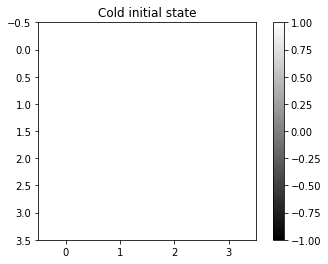

In [62]:
plt.title("Cold initial state")
plt.imshow(u1_cold.field[0,0,:,:,0].real,cmap='gray',vmin=-1,vmax=1)
plt.colorbar()

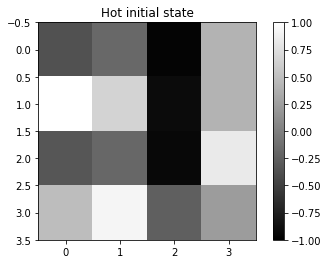

In [7]:
plt.title("Hot initial state")
plt.imshow(u1_hot.field[0,0,:,:,0].real,cmap='gray',vmin=-1,vmax=1)
plt.colorbar()

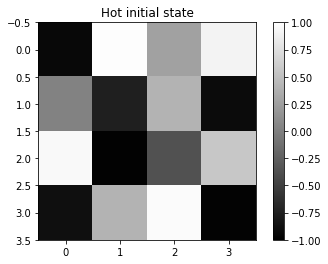

In [8]:
plt.title("Hot initial state")
plt.imshow(u1_hot.field[0,0,:,:,0].imag,cmap='gray',vmin=-1,vmax=1)
plt.colorbar()

In [9]:
bare_parameters = u1_cold.bare_parameter_generator()
bare_parameters

{'beta': 0.1}

In [10]:
def detect_equi_t(O_cold, O_hot, tol = 1e-1, step = 20):
    
    t = len(O_cold)
    
    for i in range(len(O_cold)-step):
        
        diff = np.abs(np.average(np.abs(O_cold[i:i+step]) - np.abs(O_hot[i:i+step])))
        
        if diff < tol:
            t = i
            return t
    
    return t

In [11]:
# Equilibrating phase detection
def calc_teq(bare_arg, O, tol=5e-2, step=1000,seed=0):
    t_eq = step

    O_cold = []
    O_hot = []

    u1_cold = lgt.Lattice([N,N,N,N])
    u1_cold.init_fields('U1','Cold',seed)

    u1_hot = lgt.Lattice([N,N,N,N])
    u1_hot.init_fields('U1','Hot',seed)
    
    for i in range(step):
        lgt.metropolis(u1_cold,bare_arg)
        lgt.metropolis(u1_hot,bare_arg)

        diff = np.abs(O(u1_cold.field) - O(u1_hot.field))
        O_cold.append(O(u1_cold.field))
        O_hot.append(O(u1_hot.field))

        if diff < tol:
            t_eq = i
            break

    plt.title("Estimation of autocorrelation time")
    plt.plot(np.arange(t_eq+1),O_cold,'C0',label='cold')
    plt.plot(np.arange(t_eq+1),O_hot,'C3',label='hot')
    plt.legend(loc='upper right')
    plt.xlabel("Monte Carlo time")
    plt.ylabel("Observable")
    plt.grid(True)
    plt.show()
    
    return t_eq

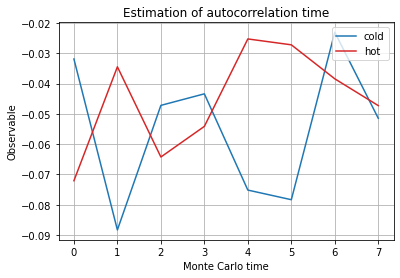

7


In [44]:
t_eq = calc_teq(bare_parameters,calcPlaqSum,tol=1e-2,seed=seed)
print(t_eq)

### 1-2. Autocorrelation function

In [45]:
def autocorrelation(conf, O, t):
    
    N = len(conf) - t
    
#     cor_hist = np.empty(N)
    
    o1o2 = 0.
    o1 = 0.
    o2 = 0.
    
    o1o1 = 0.
    o2o2 = 0.
    
    for i in range(N):
        
        o1o2 += O(conf[i])*O(conf[i+t])/N
        
        o1 += O(conf[i])/N
        o2 += O(conf[i+t])/N
        
        o1o1 += O(conf[i])*O(conf[i])/N
        o2o2 += O(conf[i+t])*O(conf[i+t])/N
        
    o1_err = np.sqrt(o1o1 - o1*o1)
    o2_err = np.sqrt(o2o2 - o2*o2)
        
    cor_t = o1o2 - o1*o2
        
    return cor_t/o1_err/o2_err

In [46]:
def detect_ac_t(ac, tol = 5e-2, step = 3):
    
    t = len(ac)
    
    for i in range(len(ac) - step):
        
        diff = np.average(np.abs(ac[i:i+step]))
        
        if diff < tol:
            t = i
            return t
    
    return t

In [64]:
u1_ac = lgt.Lattice([N,N,N,N])
u1_ac.init_fields('U1','Cold',seed=seed)

In [65]:
n_equi_ac = t_eq
for i in range(n_equi_ac):
    lgt.metropolis(u1_ac, bare_parameters)

n_conf_ac = 100
conf_ac = []
Plaq_ac = []
for e in range(n_conf_ac):
    lgt.metropolis(u1_ac,bare_parameters)
    conf_ac.append(u1_ac.field)
    Plaq = calcPlaqSum(u1_ac.field)
    Plaq_ac.append(Plaq)

In [ ]:
# Calculate autocorrelation
ac_hist = np.empty(len(conf_ac))

for i in range(len(conf_ac)):
    ac_hist[i] = autocorrelation(conf_ac,calcPlaqSum,i)

In [ ]:
t_ac = detect_ac_t(ac_hist)
t_ac

In [ ]:
plt.title("Autocorrelation plot")
plt.plot(np.arange(len(conf_ac)), ac_hist, 'C0o')
plt.xlabel("Monte Carlo time")
plt.ylabel("Autocorrelation")
plt.grid("True")

In [9]:
# calculate equilibrating phase
nt = 12
N = 6
eqSteps = 500
mcSteps = 1000

beta_list = np.linspace(1.0,1.02,nt)
n1, n2 = 1./mcSteps, 1./(mcSteps*mcSteps)

In [10]:
# for b in range(nt):
def simulate(b):
#     start = time.time()

    ensemble = []
    
    config = initialize(N)
    
    Plq1 = Plq2 = Pol_r1 = Pol_c1 = 0
    beta = beta_list[b]
    
    for i in range(eqSteps):
        mcmove(config,beta)
        
    for i in range(mcSteps):
        mcmove(config,beta)
        Plaq = calcPlaqSum(config)
        Polya = calcPolyAbs(config)
        Polya_c = calcPoly(config)
        
        Plq1 += Plaq
        Pol_r1 += Polya
        Pol_c1 += Polya_c
        Plq2 += Plaq*Plaq
        
        ensemble.append(config)
        
    Plq = n1*Plq1
    C = beta*beta*(n1*Plq2 - n2*Plq1*Plq1)
    Pol_r = n1*Pol_r1
    Pol_c = n1*Pol_c1
    
    conf_name = './data/U1%d/U1_b%0.3fN%d.npy' %(N,beta,N)
    np.save(conf_name, ensemble)
    
    return beta, Plq, C, Pol_r, Pol_c
    
#     due = time.time() - start
#     print("done beta :",beta,' ',due,' sec')

In [11]:
start = time.time()
p = mp.Pool(3)
res = p.map(simulate, range(nt))
p.close()
p.join()
b,Plq,C,Polr,Polc = np.zeros(nt), np.zeros(nt), np.zeros(nt), np.zeros(nt, dtype=np.complex128), np.zeros(nt, dtype=np.complex128)
for i, _r in enumerate(res):
    b[i], Plq[i], C[i], Polr[i], Polc[i]= _r
    
due = time.time() - start
print("time span:",due)

time span: 6475.635454177856


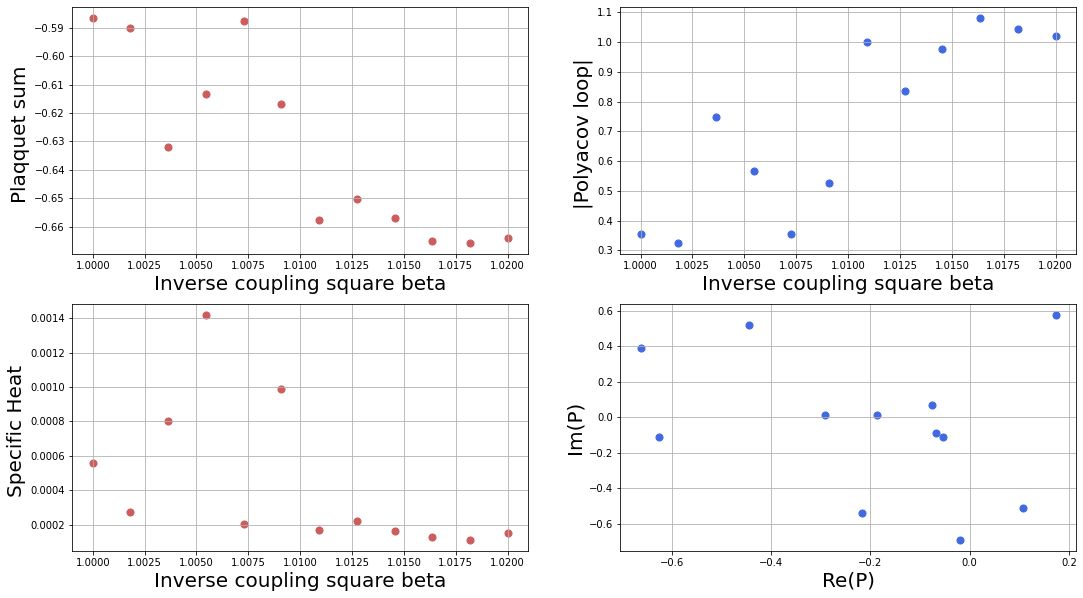

In [12]:
f = plt.figure(figsize=(18, 10)); #  


sp =  f.add_subplot(2, 2, 1 );
plt.scatter(b, Plq, s=50, marker='o', color='IndianRed')
plt.xlabel("Inverse coupling square beta", fontsize=20);
plt.ylabel("Plaqquet sum ", fontsize=20);         plt.axis('tight');
plt.grid(True)


sp =  f.add_subplot(2, 2, 2 );
plt.scatter(b, Polr, s=50, marker='o', color='RoyalBlue')
# plt.errorbar(beta_list, Pol_r, yerr=M_err, fmt='C0o')
plt.xlabel("Inverse coupling square beta", fontsize=20); 
plt.ylabel("|Polyacov loop| ", fontsize=20);   plt.axis('tight');
plt.grid(True)


sp =  f.add_subplot(2, 2, 3 );
plt.scatter(b, C, s=50, marker='o', color='IndianRed')
plt.xlabel("Inverse coupling square beta", fontsize=20);  
plt.ylabel("Specific Heat ", fontsize=20);   plt.axis('tight');   
plt.grid(True)


sp =  f.add_subplot(2, 2, 4 );
plt.scatter(Polc.real, Polc.imag, s=50, marker='o', color='RoyalBlue')
plt.xlabel("Re(P)", fontsize=20); 
plt.ylabel("Im(P)", fontsize=20);   plt.axis('tight');
plt.grid(True)